# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

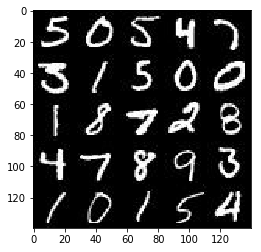

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

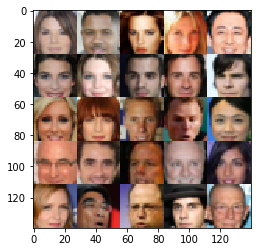

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), "input_real")
    input_z = tf.placeholder(tf.float32, (None, z_dim), "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1,2,2,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    print_every = 20
    show_every = 100
    losses = []
    n_images = 16
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 4.5889... Generator Loss: 0.0539
Epoch 0/2... Discriminator Loss: 1.7654... Generator Loss: 7.3830
Epoch 0/2... Discriminator Loss: 0.7816... Generator Loss: 4.2150
Epoch 0/2... Discriminator Loss: 0.3470... Generator Loss: 1.8844
Epoch 0/2... Discriminator Loss: 0.4269... Generator Loss: 2.1760


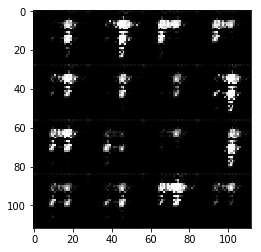

Epoch 0/2... Discriminator Loss: 0.5913... Generator Loss: 1.2102
Epoch 0/2... Discriminator Loss: 2.6551... Generator Loss: 0.1700
Epoch 0/2... Discriminator Loss: 0.0290... Generator Loss: 5.7910
Epoch 0/2... Discriminator Loss: 0.4118... Generator Loss: 2.2551
Epoch 0/2... Discriminator Loss: 0.3948... Generator Loss: 1.6926


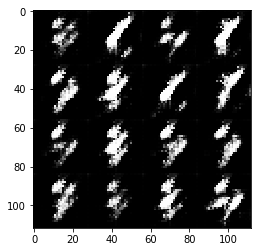

Epoch 0/2... Discriminator Loss: 0.9048... Generator Loss: 5.8853
Epoch 0/2... Discriminator Loss: 0.3234... Generator Loss: 2.2264
Epoch 0/2... Discriminator Loss: 1.4985... Generator Loss: 0.4945
Epoch 0/2... Discriminator Loss: 0.2333... Generator Loss: 3.5330
Epoch 0/2... Discriminator Loss: 0.4490... Generator Loss: 2.9282


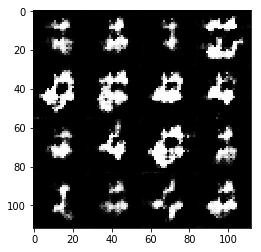

Epoch 0/2... Discriminator Loss: 0.3193... Generator Loss: 2.6473
Epoch 0/2... Discriminator Loss: 0.2527... Generator Loss: 2.5836
Epoch 0/2... Discriminator Loss: 0.7749... Generator Loss: 1.2233
Epoch 0/2... Discriminator Loss: 0.6444... Generator Loss: 1.6025
Epoch 0/2... Discriminator Loss: 0.7556... Generator Loss: 1.2016


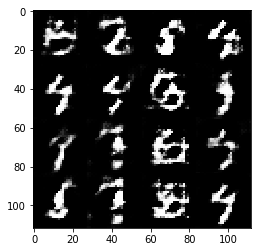

Epoch 0/2... Discriminator Loss: 0.7623... Generator Loss: 1.0556
Epoch 0/2... Discriminator Loss: 0.5610... Generator Loss: 1.3225
Epoch 0/2... Discriminator Loss: 0.6432... Generator Loss: 1.6614
Epoch 0/2... Discriminator Loss: 0.6372... Generator Loss: 2.7996
Epoch 0/2... Discriminator Loss: 1.1542... Generator Loss: 0.5667


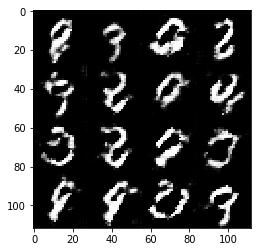

Epoch 0/2... Discriminator Loss: 1.1081... Generator Loss: 3.2024
Epoch 0/2... Discriminator Loss: 0.7643... Generator Loss: 1.1818
Epoch 0/2... Discriminator Loss: 0.7947... Generator Loss: 1.6611
Epoch 0/2... Discriminator Loss: 0.8828... Generator Loss: 2.3937
Epoch 0/2... Discriminator Loss: 1.4033... Generator Loss: 3.4885


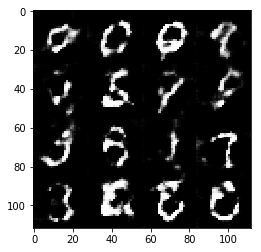

Epoch 0/2... Discriminator Loss: 0.7125... Generator Loss: 1.1786
Epoch 0/2... Discriminator Loss: 0.5687... Generator Loss: 1.6013
Epoch 0/2... Discriminator Loss: 1.0703... Generator Loss: 0.7689
Epoch 0/2... Discriminator Loss: 1.2667... Generator Loss: 0.6456
Epoch 0/2... Discriminator Loss: 0.8216... Generator Loss: 1.2977


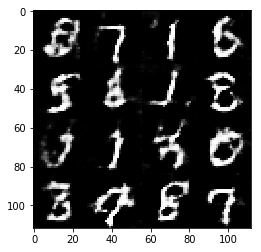

Epoch 0/2... Discriminator Loss: 0.5774... Generator Loss: 1.4200
Epoch 0/2... Discriminator Loss: 0.9998... Generator Loss: 3.0867
Epoch 0/2... Discriminator Loss: 0.6893... Generator Loss: 1.1304
Epoch 0/2... Discriminator Loss: 1.3805... Generator Loss: 0.4889
Epoch 0/2... Discriminator Loss: 1.0081... Generator Loss: 2.0214


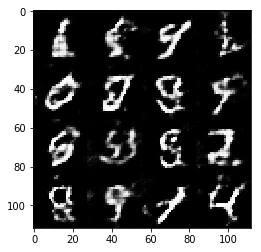

Epoch 0/2... Discriminator Loss: 1.0471... Generator Loss: 2.6065
Epoch 0/2... Discriminator Loss: 0.9706... Generator Loss: 0.7389
Epoch 0/2... Discriminator Loss: 1.0107... Generator Loss: 2.8505
Epoch 0/2... Discriminator Loss: 0.9651... Generator Loss: 0.9350
Epoch 0/2... Discriminator Loss: 0.9009... Generator Loss: 0.8863


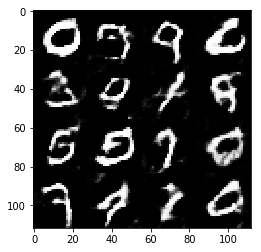

Epoch 0/2... Discriminator Loss: 0.9955... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 2.6382
Epoch 1/2... Discriminator Loss: 0.8719... Generator Loss: 0.9767
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.1981... Generator Loss: 0.5833


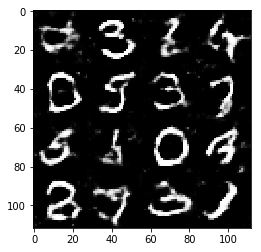

Epoch 1/2... Discriminator Loss: 0.8559... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.0420... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 2.4035
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.8706


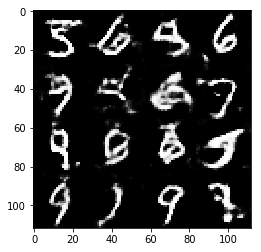

Epoch 1/2... Discriminator Loss: 1.0159... Generator Loss: 0.6487
Epoch 1/2... Discriminator Loss: 2.8712... Generator Loss: 5.3416
Epoch 1/2... Discriminator Loss: 1.2713... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 0.8580... Generator Loss: 1.0348
Epoch 1/2... Discriminator Loss: 2.7322... Generator Loss: 0.1240


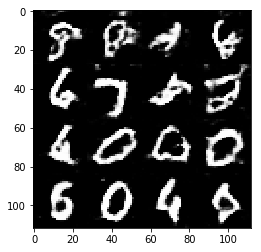

Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 2.5375
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 0.7305
Epoch 1/2... Discriminator Loss: 1.0362... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.7900... Generator Loss: 3.4536


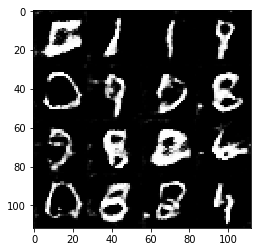

Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.7080
Epoch 1/2... Discriminator Loss: 0.8729... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 0.6686... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 3.4955
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 1.4661


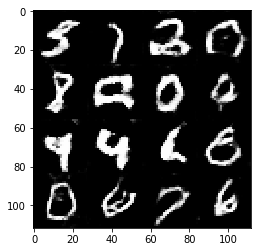

Epoch 1/2... Discriminator Loss: 1.0073... Generator Loss: 1.5708
Epoch 1/2... Discriminator Loss: 0.8551... Generator Loss: 1.6875
Epoch 1/2... Discriminator Loss: 0.7538... Generator Loss: 1.0934
Epoch 1/2... Discriminator Loss: 0.9334... Generator Loss: 0.7987
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 1.5809


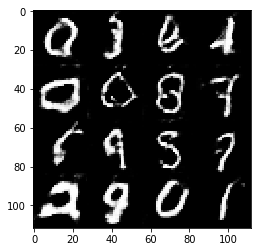

Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.4042
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.7907
Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 2.0871
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 2.6941


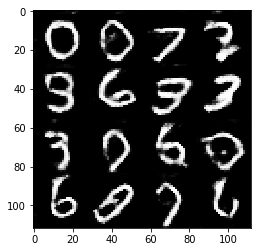

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 0.7352... Generator Loss: 1.9749
Epoch 1/2... Discriminator Loss: 1.1853... Generator Loss: 0.4985
Epoch 1/2... Discriminator Loss: 2.8944... Generator Loss: 5.0792
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 0.7921


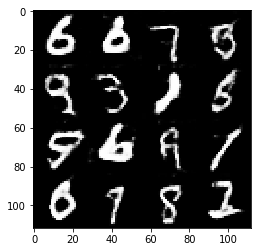

Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.6263
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.5805
Epoch 1/2... Discriminator Loss: 1.1541... Generator Loss: 0.5280
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 2.5041


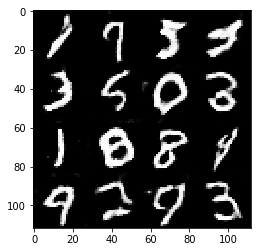

Epoch 1/2... Discriminator Loss: 0.7633... Generator Loss: 1.1016
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 0.5731
Epoch 1/2... Discriminator Loss: 0.6871... Generator Loss: 1.2559


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 4.4342... Generator Loss: 0.0130
Epoch 0/1... Discriminator Loss: 0.5641... Generator Loss: 1.8439
Epoch 0/1... Discriminator Loss: 0.4896... Generator Loss: 7.7048
Epoch 0/1... Discriminator Loss: 1.2099... Generator Loss: 3.5292
Epoch 0/1... Discriminator Loss: 1.1268... Generator Loss: 10.7168


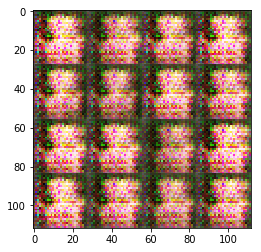

Epoch 0/1... Discriminator Loss: 0.2584... Generator Loss: 2.8458
Epoch 0/1... Discriminator Loss: 0.2566... Generator Loss: 1.8600
Epoch 0/1... Discriminator Loss: 0.3160... Generator Loss: 1.9050
Epoch 0/1... Discriminator Loss: 1.2875... Generator Loss: 8.0683
Epoch 0/1... Discriminator Loss: 0.6611... Generator Loss: 1.1676


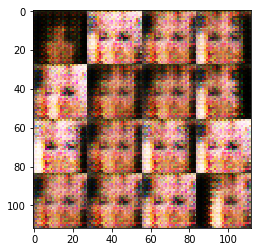

Epoch 0/1... Discriminator Loss: 1.5458... Generator Loss: 0.3872
Epoch 0/1... Discriminator Loss: 0.7229... Generator Loss: 1.0176
Epoch 0/1... Discriminator Loss: 0.9685... Generator Loss: 2.0150
Epoch 0/1... Discriminator Loss: 0.7208... Generator Loss: 1.2567
Epoch 0/1... Discriminator Loss: 1.3802... Generator Loss: 1.2691


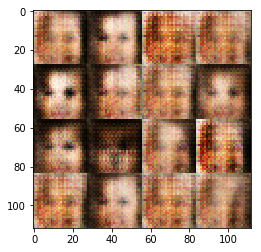

Epoch 0/1... Discriminator Loss: 0.7233... Generator Loss: 1.0501
Epoch 0/1... Discriminator Loss: 0.7833... Generator Loss: 1.3734
Epoch 0/1... Discriminator Loss: 1.3093... Generator Loss: 0.7390
Epoch 0/1... Discriminator Loss: 1.0883... Generator Loss: 2.3695
Epoch 0/1... Discriminator Loss: 0.3889... Generator Loss: 1.6333


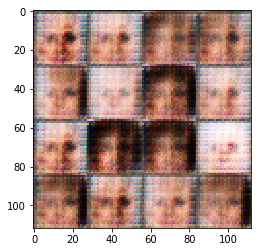

Epoch 0/1... Discriminator Loss: 0.8504... Generator Loss: 0.7599
Epoch 0/1... Discriminator Loss: 0.8192... Generator Loss: 0.9050
Epoch 0/1... Discriminator Loss: 0.8159... Generator Loss: 0.8805
Epoch 0/1... Discriminator Loss: 0.9262... Generator Loss: 1.4074
Epoch 0/1... Discriminator Loss: 0.5188... Generator Loss: 2.5766


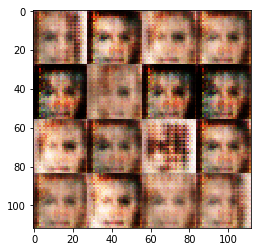

Epoch 0/1... Discriminator Loss: 0.9210... Generator Loss: 0.9062
Epoch 0/1... Discriminator Loss: 0.8404... Generator Loss: 0.9733
Epoch 0/1... Discriminator Loss: 0.9968... Generator Loss: 0.9705
Epoch 0/1... Discriminator Loss: 1.0727... Generator Loss: 1.3948
Epoch 0/1... Discriminator Loss: 1.0180... Generator Loss: 1.4147


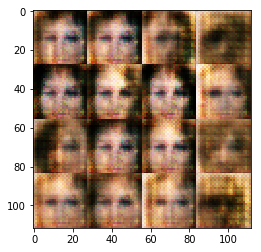

Epoch 0/1... Discriminator Loss: 0.7276... Generator Loss: 1.4269
Epoch 0/1... Discriminator Loss: 1.2586... Generator Loss: 0.6194
Epoch 0/1... Discriminator Loss: 0.8895... Generator Loss: 1.2054
Epoch 0/1... Discriminator Loss: 1.4939... Generator Loss: 0.6260
Epoch 0/1... Discriminator Loss: 1.0880... Generator Loss: 1.4315


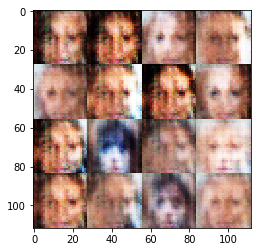

Epoch 0/1... Discriminator Loss: 1.0754... Generator Loss: 1.2155
Epoch 0/1... Discriminator Loss: 0.8813... Generator Loss: 1.1592
Epoch 0/1... Discriminator Loss: 1.0037... Generator Loss: 0.8609
Epoch 0/1... Discriminator Loss: 0.8594... Generator Loss: 1.6297
Epoch 0/1... Discriminator Loss: 1.0014... Generator Loss: 1.3859


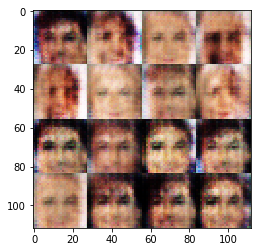

Epoch 0/1... Discriminator Loss: 0.6738... Generator Loss: 1.4583
Epoch 0/1... Discriminator Loss: 0.8090... Generator Loss: 0.9850
Epoch 0/1... Discriminator Loss: 1.3359... Generator Loss: 0.5483
Epoch 0/1... Discriminator Loss: 1.0929... Generator Loss: 2.1035
Epoch 0/1... Discriminator Loss: 0.9052... Generator Loss: 1.2329


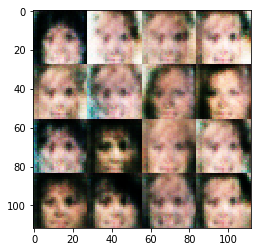

Epoch 0/1... Discriminator Loss: 0.8356... Generator Loss: 1.1507
Epoch 0/1... Discriminator Loss: 1.0497... Generator Loss: 2.4629
Epoch 0/1... Discriminator Loss: 1.0038... Generator Loss: 0.9131
Epoch 0/1... Discriminator Loss: 0.8654... Generator Loss: 1.0760
Epoch 0/1... Discriminator Loss: 1.2856... Generator Loss: 0.4562


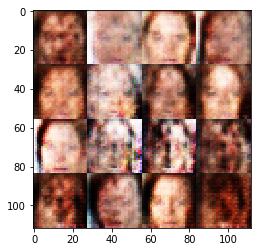

Epoch 0/1... Discriminator Loss: 1.0074... Generator Loss: 1.9048
Epoch 0/1... Discriminator Loss: 0.9124... Generator Loss: 1.0670
Epoch 0/1... Discriminator Loss: 1.0089... Generator Loss: 1.0027
Epoch 0/1... Discriminator Loss: 0.8938... Generator Loss: 1.2550
Epoch 0/1... Discriminator Loss: 1.0724... Generator Loss: 0.7663


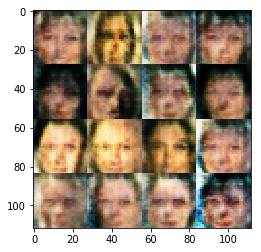

Epoch 0/1... Discriminator Loss: 1.0522... Generator Loss: 0.8895
Epoch 0/1... Discriminator Loss: 1.0631... Generator Loss: 0.7303
Epoch 0/1... Discriminator Loss: 0.8288... Generator Loss: 1.3329
Epoch 0/1... Discriminator Loss: 0.7609... Generator Loss: 0.8739
Epoch 0/1... Discriminator Loss: 0.8277... Generator Loss: 1.0962


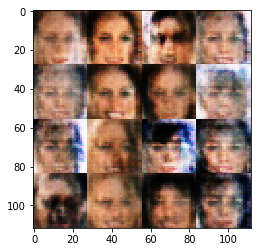

Epoch 0/1... Discriminator Loss: 0.9535... Generator Loss: 1.2455
Epoch 0/1... Discriminator Loss: 1.2073... Generator Loss: 0.6046
Epoch 0/1... Discriminator Loss: 0.8432... Generator Loss: 1.9061
Epoch 0/1... Discriminator Loss: 0.7524... Generator Loss: 1.2054
Epoch 0/1... Discriminator Loss: 1.1669... Generator Loss: 0.6262


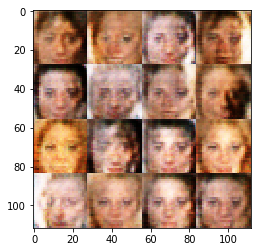

Epoch 0/1... Discriminator Loss: 1.1834... Generator Loss: 0.7358
Epoch 0/1... Discriminator Loss: 0.8449... Generator Loss: 1.1901
Epoch 0/1... Discriminator Loss: 0.8991... Generator Loss: 0.9033
Epoch 0/1... Discriminator Loss: 0.9619... Generator Loss: 0.8133
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 1.6396


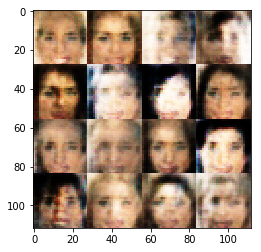

Epoch 0/1... Discriminator Loss: 1.2740... Generator Loss: 1.8823
Epoch 0/1... Discriminator Loss: 1.3215... Generator Loss: 0.6747
Epoch 0/1... Discriminator Loss: 1.0468... Generator Loss: 0.8803
Epoch 0/1... Discriminator Loss: 0.9849... Generator Loss: 1.5511
Epoch 0/1... Discriminator Loss: 1.3419... Generator Loss: 2.0156


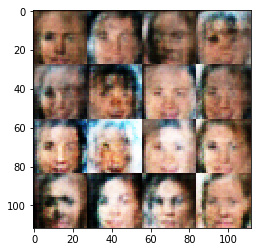

Epoch 0/1... Discriminator Loss: 1.0830... Generator Loss: 0.8572
Epoch 0/1... Discriminator Loss: 1.1721... Generator Loss: 1.0592
Epoch 0/1... Discriminator Loss: 0.6210... Generator Loss: 2.1312
Epoch 0/1... Discriminator Loss: 1.2135... Generator Loss: 1.7693
Epoch 0/1... Discriminator Loss: 0.9504... Generator Loss: 1.3468


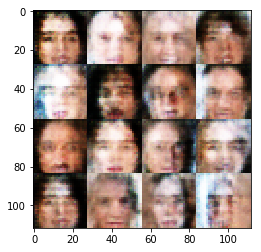

Epoch 0/1... Discriminator Loss: 1.1431... Generator Loss: 0.6400
Epoch 0/1... Discriminator Loss: 1.3964... Generator Loss: 2.1353
Epoch 0/1... Discriminator Loss: 1.2447... Generator Loss: 0.5054
Epoch 0/1... Discriminator Loss: 1.1720... Generator Loss: 0.5668
Epoch 0/1... Discriminator Loss: 0.9990... Generator Loss: 1.3134


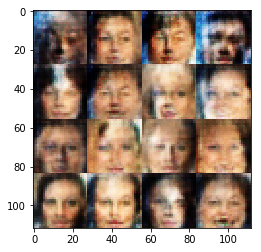

Epoch 0/1... Discriminator Loss: 1.0031... Generator Loss: 1.1906
Epoch 0/1... Discriminator Loss: 1.0093... Generator Loss: 0.6580
Epoch 0/1... Discriminator Loss: 0.9398... Generator Loss: 0.7913
Epoch 0/1... Discriminator Loss: 1.1179... Generator Loss: 0.9881
Epoch 0/1... Discriminator Loss: 0.9538... Generator Loss: 1.2517


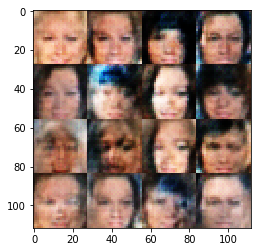

Epoch 0/1... Discriminator Loss: 0.8499... Generator Loss: 1.3355
Epoch 0/1... Discriminator Loss: 1.0172... Generator Loss: 1.5291
Epoch 0/1... Discriminator Loss: 0.9775... Generator Loss: 1.0885
Epoch 0/1... Discriminator Loss: 0.9383... Generator Loss: 1.0944
Epoch 0/1... Discriminator Loss: 0.9425... Generator Loss: 0.9313


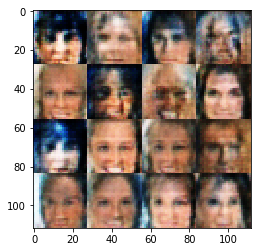

Epoch 0/1... Discriminator Loss: 1.5369... Generator Loss: 0.3957
Epoch 0/1... Discriminator Loss: 0.8391... Generator Loss: 0.8701
Epoch 0/1... Discriminator Loss: 0.9758... Generator Loss: 1.7652
Epoch 0/1... Discriminator Loss: 0.8410... Generator Loss: 1.4926
Epoch 0/1... Discriminator Loss: 1.0670... Generator Loss: 1.0954


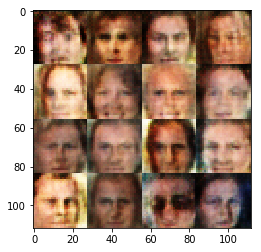

Epoch 0/1... Discriminator Loss: 1.2499... Generator Loss: 0.4762
Epoch 0/1... Discriminator Loss: 1.1029... Generator Loss: 1.7672
Epoch 0/1... Discriminator Loss: 0.9829... Generator Loss: 0.9642
Epoch 0/1... Discriminator Loss: 1.0863... Generator Loss: 0.6897
Epoch 0/1... Discriminator Loss: 1.0469... Generator Loss: 0.6405


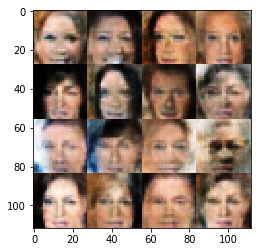

Epoch 0/1... Discriminator Loss: 0.9454... Generator Loss: 0.9668
Epoch 0/1... Discriminator Loss: 1.0289... Generator Loss: 1.2051
Epoch 0/1... Discriminator Loss: 0.8326... Generator Loss: 1.2389
Epoch 0/1... Discriminator Loss: 1.0068... Generator Loss: 1.1392
Epoch 0/1... Discriminator Loss: 0.9306... Generator Loss: 0.9845


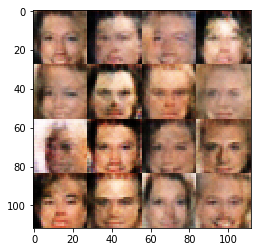

Epoch 0/1... Discriminator Loss: 0.8683... Generator Loss: 1.1200
Epoch 0/1... Discriminator Loss: 1.2608... Generator Loss: 0.4871
Epoch 0/1... Discriminator Loss: 1.1312... Generator Loss: 0.7105
Epoch 0/1... Discriminator Loss: 1.0984... Generator Loss: 1.2076
Epoch 0/1... Discriminator Loss: 1.0789... Generator Loss: 0.7380


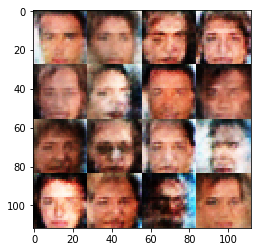

Epoch 0/1... Discriminator Loss: 0.8912... Generator Loss: 1.2114
Epoch 0/1... Discriminator Loss: 1.2613... Generator Loss: 1.7174
Epoch 0/1... Discriminator Loss: 1.0972... Generator Loss: 0.7705
Epoch 0/1... Discriminator Loss: 0.9613... Generator Loss: 1.4482
Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 1.4060


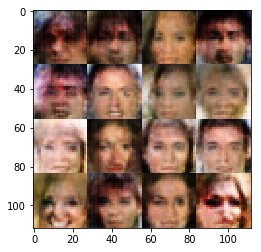

Epoch 0/1... Discriminator Loss: 0.8566... Generator Loss: 1.0727
Epoch 0/1... Discriminator Loss: 1.2308... Generator Loss: 0.6104
Epoch 0/1... Discriminator Loss: 0.9405... Generator Loss: 0.8703
Epoch 0/1... Discriminator Loss: 0.9801... Generator Loss: 0.9940
Epoch 0/1... Discriminator Loss: 0.7992... Generator Loss: 1.5540


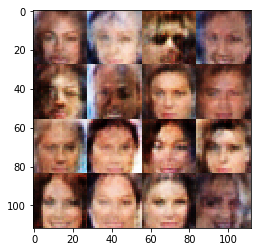

Epoch 0/1... Discriminator Loss: 0.8327... Generator Loss: 1.4186
Epoch 0/1... Discriminator Loss: 1.0318... Generator Loss: 0.7107
Epoch 0/1... Discriminator Loss: 0.8859... Generator Loss: 0.8412
Epoch 0/1... Discriminator Loss: 1.0396... Generator Loss: 0.6682
Epoch 0/1... Discriminator Loss: 1.1039... Generator Loss: 0.6123


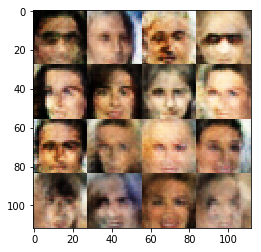

Epoch 0/1... Discriminator Loss: 1.2456... Generator Loss: 0.4726
Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 0.7636
Epoch 0/1... Discriminator Loss: 0.6976... Generator Loss: 1.2557
Epoch 0/1... Discriminator Loss: 0.6777... Generator Loss: 1.2845
Epoch 0/1... Discriminator Loss: 1.0858... Generator Loss: 0.6692


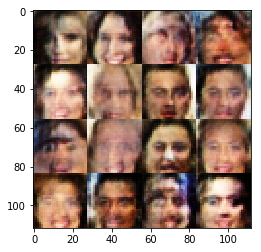

Epoch 0/1... Discriminator Loss: 0.8495... Generator Loss: 0.8626
Epoch 0/1... Discriminator Loss: 1.1593... Generator Loss: 0.5882
Epoch 0/1... Discriminator Loss: 0.9048... Generator Loss: 1.4940
Epoch 0/1... Discriminator Loss: 1.2386... Generator Loss: 1.4386
Epoch 0/1... Discriminator Loss: 1.0843... Generator Loss: 1.8658


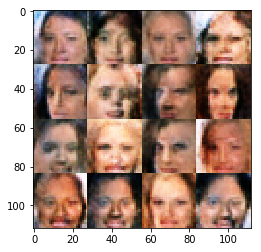

Epoch 0/1... Discriminator Loss: 1.0820... Generator Loss: 1.0647
Epoch 0/1... Discriminator Loss: 1.0990... Generator Loss: 0.6831
Epoch 0/1... Discriminator Loss: 1.1639... Generator Loss: 0.5670
Epoch 0/1... Discriminator Loss: 1.0741... Generator Loss: 0.5735
Epoch 0/1... Discriminator Loss: 0.9696... Generator Loss: 1.0920


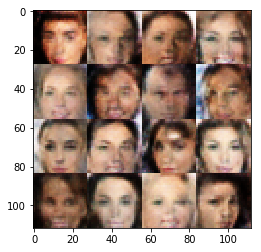

Epoch 0/1... Discriminator Loss: 0.7269... Generator Loss: 1.3633
Epoch 0/1... Discriminator Loss: 1.0651... Generator Loss: 1.7707
Epoch 0/1... Discriminator Loss: 0.8189... Generator Loss: 1.1368
Epoch 0/1... Discriminator Loss: 1.0760... Generator Loss: 0.9144
Epoch 0/1... Discriminator Loss: 1.0347... Generator Loss: 0.8758


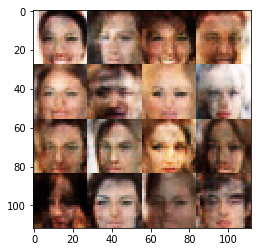

Epoch 0/1... Discriminator Loss: 0.9143... Generator Loss: 0.7793
Epoch 0/1... Discriminator Loss: 0.8565... Generator Loss: 0.8095
Epoch 0/1... Discriminator Loss: 0.7353... Generator Loss: 1.1736
Epoch 0/1... Discriminator Loss: 1.2629... Generator Loss: 0.4963
Epoch 0/1... Discriminator Loss: 0.9898... Generator Loss: 0.6620


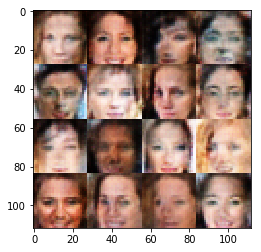

Epoch 0/1... Discriminator Loss: 0.9592... Generator Loss: 1.2135
Epoch 0/1... Discriminator Loss: 0.7906... Generator Loss: 1.4530
Epoch 0/1... Discriminator Loss: 0.7849... Generator Loss: 1.7610
Epoch 0/1... Discriminator Loss: 0.8475... Generator Loss: 1.2572
Epoch 0/1... Discriminator Loss: 1.0951... Generator Loss: 0.6482


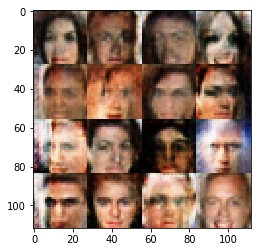

Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 1.3691
Epoch 0/1... Discriminator Loss: 0.7157... Generator Loss: 1.1140
Epoch 0/1... Discriminator Loss: 0.7213... Generator Loss: 1.1778
Epoch 0/1... Discriminator Loss: 0.7793... Generator Loss: 1.1813
Epoch 0/1... Discriminator Loss: 1.0900... Generator Loss: 0.6006


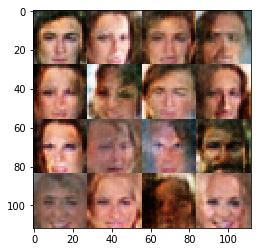

Epoch 0/1... Discriminator Loss: 0.8782... Generator Loss: 1.5366
Epoch 0/1... Discriminator Loss: 0.8351... Generator Loss: 1.0456
Epoch 0/1... Discriminator Loss: 0.9869... Generator Loss: 0.9248
Epoch 0/1... Discriminator Loss: 1.2676... Generator Loss: 1.8059
Epoch 0/1... Discriminator Loss: 0.8952... Generator Loss: 1.1491


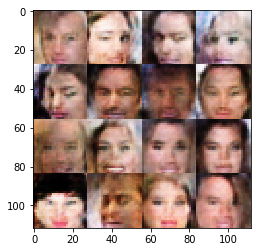

Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 0.9656
Epoch 0/1... Discriminator Loss: 0.9204... Generator Loss: 0.7387
Epoch 0/1... Discriminator Loss: 1.4421... Generator Loss: 0.4419
Epoch 0/1... Discriminator Loss: 0.9119... Generator Loss: 0.8601
Epoch 0/1... Discriminator Loss: 0.9743... Generator Loss: 0.8582


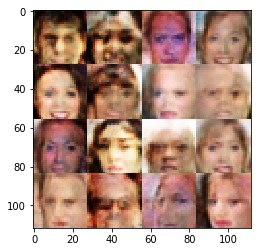

Epoch 0/1... Discriminator Loss: 0.9156... Generator Loss: 1.4282
Epoch 0/1... Discriminator Loss: 1.0982... Generator Loss: 0.8415
Epoch 0/1... Discriminator Loss: 1.1238... Generator Loss: 0.5799
Epoch 0/1... Discriminator Loss: 1.5368... Generator Loss: 0.3997
Epoch 0/1... Discriminator Loss: 1.0968... Generator Loss: 0.6369


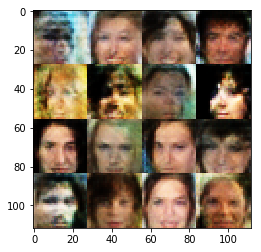

Epoch 0/1... Discriminator Loss: 0.7443... Generator Loss: 1.5324
Epoch 0/1... Discriminator Loss: 1.3142... Generator Loss: 0.4201
Epoch 0/1... Discriminator Loss: 1.3774... Generator Loss: 0.4062
Epoch 0/1... Discriminator Loss: 0.8647... Generator Loss: 1.2977
Epoch 0/1... Discriminator Loss: 1.2594... Generator Loss: 0.4890


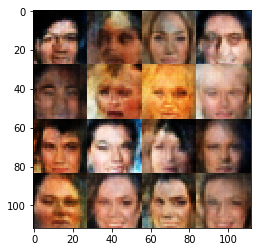

Epoch 0/1... Discriminator Loss: 0.9167... Generator Loss: 0.9518
Epoch 0/1... Discriminator Loss: 0.7919... Generator Loss: 0.9128
Epoch 0/1... Discriminator Loss: 0.9557... Generator Loss: 0.8211
Epoch 0/1... Discriminator Loss: 0.6555... Generator Loss: 1.4379
Epoch 0/1... Discriminator Loss: 0.9682... Generator Loss: 0.9140


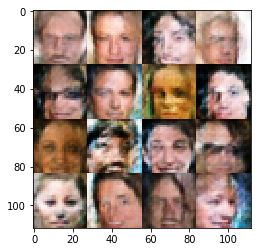

Epoch 0/1... Discriminator Loss: 0.9495... Generator Loss: 1.2517
Epoch 0/1... Discriminator Loss: 1.1383... Generator Loss: 0.5720
Epoch 0/1... Discriminator Loss: 1.1968... Generator Loss: 1.9086
Epoch 0/1... Discriminator Loss: 0.7773... Generator Loss: 1.1207
Epoch 0/1... Discriminator Loss: 0.9961... Generator Loss: 0.9260


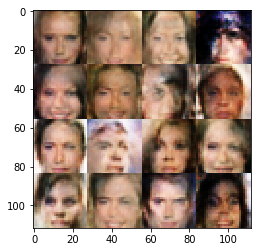

Epoch 0/1... Discriminator Loss: 1.3840... Generator Loss: 0.6090
Epoch 0/1... Discriminator Loss: 0.9549... Generator Loss: 0.8250
Epoch 0/1... Discriminator Loss: 1.3126... Generator Loss: 1.4835
Epoch 0/1... Discriminator Loss: 0.8848... Generator Loss: 1.0260
Epoch 0/1... Discriminator Loss: 1.1103... Generator Loss: 1.4072


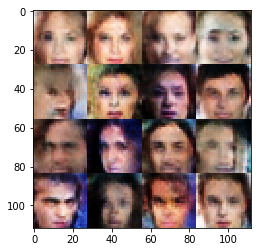

Epoch 0/1... Discriminator Loss: 1.0203... Generator Loss: 0.6690
Epoch 0/1... Discriminator Loss: 0.7132... Generator Loss: 1.4957
Epoch 0/1... Discriminator Loss: 1.0605... Generator Loss: 0.8269
Epoch 0/1... Discriminator Loss: 0.9919... Generator Loss: 0.6999
Epoch 0/1... Discriminator Loss: 1.1952... Generator Loss: 0.9212


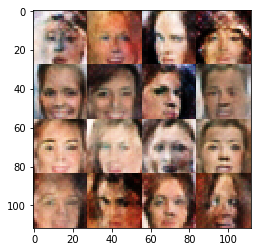

Epoch 0/1... Discriminator Loss: 0.8649... Generator Loss: 0.8868
Epoch 0/1... Discriminator Loss: 1.3573... Generator Loss: 1.0084
Epoch 0/1... Discriminator Loss: 0.7842... Generator Loss: 1.3222
Epoch 0/1... Discriminator Loss: 0.9606... Generator Loss: 0.8552
Epoch 0/1... Discriminator Loss: 0.9549... Generator Loss: 0.9553


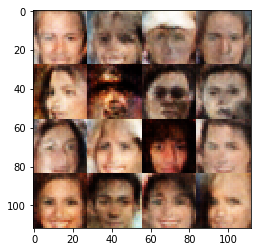

Epoch 0/1... Discriminator Loss: 1.1822... Generator Loss: 0.4768
Epoch 0/1... Discriminator Loss: 1.2334... Generator Loss: 1.4521
Epoch 0/1... Discriminator Loss: 1.4065... Generator Loss: 0.4163
Epoch 0/1... Discriminator Loss: 0.9522... Generator Loss: 0.9236
Epoch 0/1... Discriminator Loss: 1.1411... Generator Loss: 0.6787


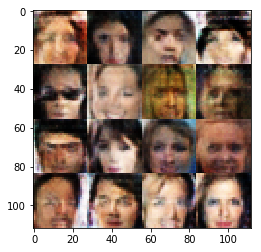

Epoch 0/1... Discriminator Loss: 1.1397... Generator Loss: 0.7195
Epoch 0/1... Discriminator Loss: 1.2005... Generator Loss: 0.5034
Epoch 0/1... Discriminator Loss: 0.8265... Generator Loss: 1.4480
Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 0.8409
Epoch 0/1... Discriminator Loss: 1.1619... Generator Loss: 0.6050


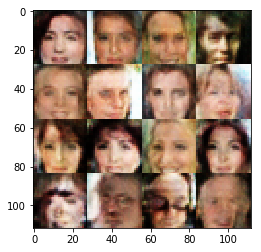

Epoch 0/1... Discriminator Loss: 0.8950... Generator Loss: 0.6957
Epoch 0/1... Discriminator Loss: 1.0018... Generator Loss: 0.8000
Epoch 0/1... Discriminator Loss: 1.0149... Generator Loss: 0.8976
Epoch 0/1... Discriminator Loss: 1.2743... Generator Loss: 0.5113
Epoch 0/1... Discriminator Loss: 0.9972... Generator Loss: 1.2463


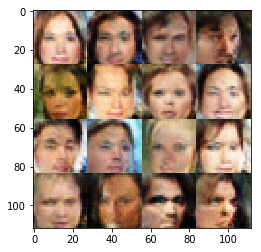

Epoch 0/1... Discriminator Loss: 1.1193... Generator Loss: 0.6049
Epoch 0/1... Discriminator Loss: 0.8222... Generator Loss: 1.0263
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 0.5446
Epoch 0/1... Discriminator Loss: 1.2131... Generator Loss: 0.4875
Epoch 0/1... Discriminator Loss: 1.2213... Generator Loss: 1.4818


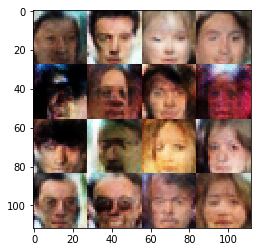

Epoch 0/1... Discriminator Loss: 1.0245... Generator Loss: 0.9238
Epoch 0/1... Discriminator Loss: 0.9238... Generator Loss: 1.0463
Epoch 0/1... Discriminator Loss: 1.1690... Generator Loss: 1.2615
Epoch 0/1... Discriminator Loss: 0.7746... Generator Loss: 1.6083
Epoch 0/1... Discriminator Loss: 0.8713... Generator Loss: 1.3622


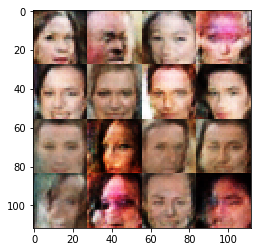

Epoch 0/1... Discriminator Loss: 1.0275... Generator Loss: 0.7523
Epoch 0/1... Discriminator Loss: 0.9697... Generator Loss: 0.8226
Epoch 0/1... Discriminator Loss: 1.0754... Generator Loss: 0.7266
Epoch 0/1... Discriminator Loss: 1.1727... Generator Loss: 1.2139
Epoch 0/1... Discriminator Loss: 0.8606... Generator Loss: 1.0120


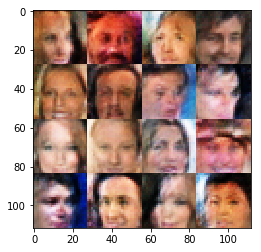

Epoch 0/1... Discriminator Loss: 1.1161... Generator Loss: 0.5724
Epoch 0/1... Discriminator Loss: 0.8418... Generator Loss: 1.1587
Epoch 0/1... Discriminator Loss: 1.0489... Generator Loss: 0.6287
Epoch 0/1... Discriminator Loss: 1.0659... Generator Loss: 0.9376
Epoch 0/1... Discriminator Loss: 1.1445... Generator Loss: 0.7255


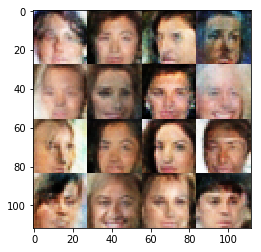

Epoch 0/1... Discriminator Loss: 0.9159... Generator Loss: 1.2690
Epoch 0/1... Discriminator Loss: 0.8793... Generator Loss: 1.2988
Epoch 0/1... Discriminator Loss: 1.2850... Generator Loss: 0.4539
Epoch 0/1... Discriminator Loss: 0.7360... Generator Loss: 1.3375
Epoch 0/1... Discriminator Loss: 0.9024... Generator Loss: 1.1378


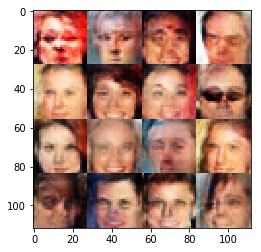

Epoch 0/1... Discriminator Loss: 0.8864... Generator Loss: 0.8379
Epoch 0/1... Discriminator Loss: 1.6482... Generator Loss: 0.3480
Epoch 0/1... Discriminator Loss: 1.1370... Generator Loss: 0.6986
Epoch 0/1... Discriminator Loss: 1.4317... Generator Loss: 0.5038
Epoch 0/1... Discriminator Loss: 1.0445... Generator Loss: 0.6931


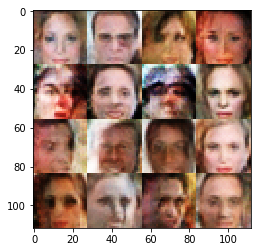

Epoch 0/1... Discriminator Loss: 1.0156... Generator Loss: 1.1621
Epoch 0/1... Discriminator Loss: 1.4970... Generator Loss: 0.5453
Epoch 0/1... Discriminator Loss: 1.6074... Generator Loss: 0.3230
Epoch 0/1... Discriminator Loss: 0.9848... Generator Loss: 1.0665
Epoch 0/1... Discriminator Loss: 0.8125... Generator Loss: 1.4829


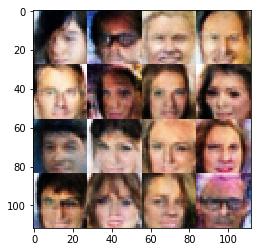

Epoch 0/1... Discriminator Loss: 1.0925... Generator Loss: 0.9374
Epoch 0/1... Discriminator Loss: 1.2974... Generator Loss: 0.4591
Epoch 0/1... Discriminator Loss: 0.8978... Generator Loss: 1.2229
Epoch 0/1... Discriminator Loss: 1.1787... Generator Loss: 0.5758
Epoch 0/1... Discriminator Loss: 0.9925... Generator Loss: 0.7864


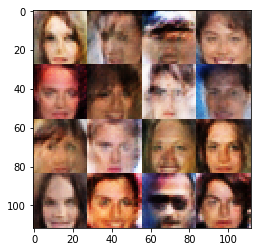

Epoch 0/1... Discriminator Loss: 0.9886... Generator Loss: 0.7587
Epoch 0/1... Discriminator Loss: 1.0839... Generator Loss: 0.8954
Epoch 0/1... Discriminator Loss: 1.0747... Generator Loss: 0.7893
Epoch 0/1... Discriminator Loss: 1.1435... Generator Loss: 0.7541
Epoch 0/1... Discriminator Loss: 1.0186... Generator Loss: 0.6674


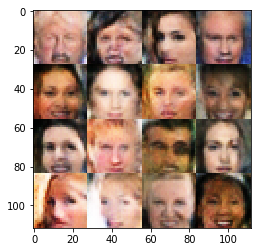

Epoch 0/1... Discriminator Loss: 0.8172... Generator Loss: 1.1130
Epoch 0/1... Discriminator Loss: 1.4048... Generator Loss: 0.4495
Epoch 0/1... Discriminator Loss: 0.9679... Generator Loss: 1.0849
Epoch 0/1... Discriminator Loss: 1.3710... Generator Loss: 0.4559
Epoch 0/1... Discriminator Loss: 1.2662... Generator Loss: 1.5765


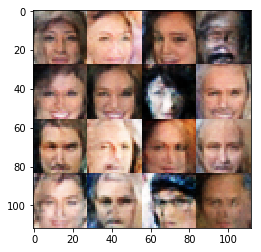

Epoch 0/1... Discriminator Loss: 1.1376... Generator Loss: 0.6283
Epoch 0/1... Discriminator Loss: 0.9671... Generator Loss: 0.8016
Epoch 0/1... Discriminator Loss: 0.8804... Generator Loss: 1.1726
Epoch 0/1... Discriminator Loss: 1.0890... Generator Loss: 0.9836
Epoch 0/1... Discriminator Loss: 1.1515... Generator Loss: 0.8245


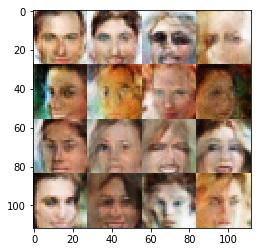

Epoch 0/1... Discriminator Loss: 1.2161... Generator Loss: 0.5134
Epoch 0/1... Discriminator Loss: 0.7663... Generator Loss: 1.2372
Epoch 0/1... Discriminator Loss: 0.9303... Generator Loss: 0.8830
Epoch 0/1... Discriminator Loss: 0.7396... Generator Loss: 1.0296
Epoch 0/1... Discriminator Loss: 1.0421... Generator Loss: 0.8351


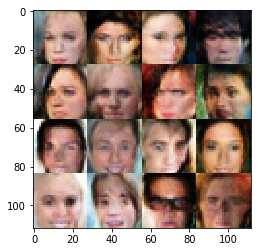

Epoch 0/1... Discriminator Loss: 0.9489... Generator Loss: 0.9214
Epoch 0/1... Discriminator Loss: 0.8691... Generator Loss: 0.7871
Epoch 0/1... Discriminator Loss: 0.9564... Generator Loss: 1.1579
Epoch 0/1... Discriminator Loss: 0.9240... Generator Loss: 0.7413
Epoch 0/1... Discriminator Loss: 1.1298... Generator Loss: 0.6970


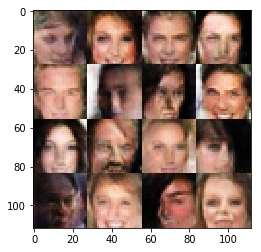

Epoch 0/1... Discriminator Loss: 1.0463... Generator Loss: 0.6414
Epoch 0/1... Discriminator Loss: 0.9674... Generator Loss: 1.0606
Epoch 0/1... Discriminator Loss: 0.8290... Generator Loss: 0.9598
Epoch 0/1... Discriminator Loss: 0.8458... Generator Loss: 1.0732
Epoch 0/1... Discriminator Loss: 0.8514... Generator Loss: 0.8057


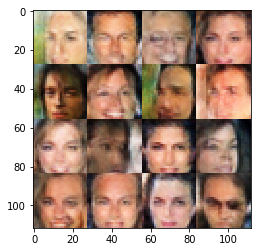

Epoch 0/1... Discriminator Loss: 0.9149... Generator Loss: 1.4510
Epoch 0/1... Discriminator Loss: 1.1734... Generator Loss: 0.5236
Epoch 0/1... Discriminator Loss: 1.2795... Generator Loss: 0.5439
Epoch 0/1... Discriminator Loss: 1.0695... Generator Loss: 0.9573
Epoch 0/1... Discriminator Loss: 0.9865... Generator Loss: 1.2607


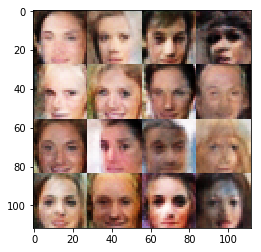

Epoch 0/1... Discriminator Loss: 1.0781... Generator Loss: 1.2666
Epoch 0/1... Discriminator Loss: 0.9974... Generator Loss: 1.0361
Epoch 0/1... Discriminator Loss: 1.0500... Generator Loss: 0.8108
Epoch 0/1... Discriminator Loss: 1.0391... Generator Loss: 0.6203
Epoch 0/1... Discriminator Loss: 1.1247... Generator Loss: 0.7300


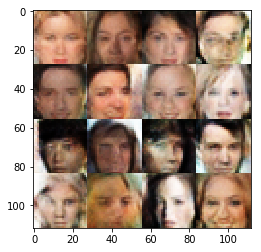

Epoch 0/1... Discriminator Loss: 1.3833... Generator Loss: 0.5230
Epoch 0/1... Discriminator Loss: 0.9366... Generator Loss: 0.7471
Epoch 0/1... Discriminator Loss: 0.8621... Generator Loss: 1.1994
Epoch 0/1... Discriminator Loss: 1.0629... Generator Loss: 0.8418
Epoch 0/1... Discriminator Loss: 1.1940... Generator Loss: 0.6207


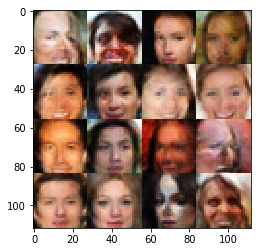

Epoch 0/1... Discriminator Loss: 1.2803... Generator Loss: 0.5207
Epoch 0/1... Discriminator Loss: 1.0447... Generator Loss: 1.2069
Epoch 0/1... Discriminator Loss: 1.1069... Generator Loss: 0.7480
Epoch 0/1... Discriminator Loss: 1.4601... Generator Loss: 0.3814
Epoch 0/1... Discriminator Loss: 1.2740... Generator Loss: 1.0103


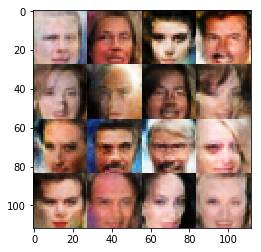

Epoch 0/1... Discriminator Loss: 1.2513... Generator Loss: 0.4745


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.